In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MulticlassAccuracy

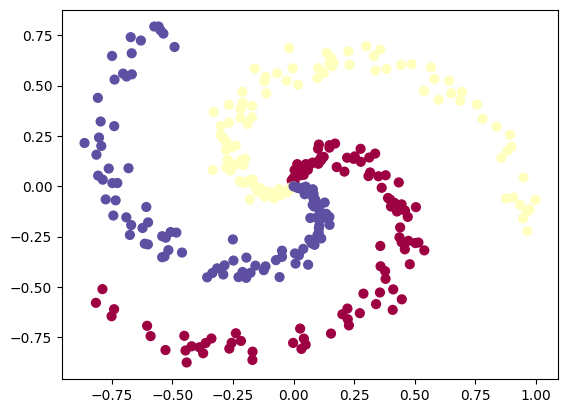

In [ ]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
x = np.zeros((N*K,D)) # data matrix (each row = single example)
Y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  Y[ix] = j
# lets visualize the data:
plt.scatter(x[:, 0], x[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
X = torch.from_numpy(np.array(x)).type(torch.float)
y = torch.from_numpy(np.array(Y)).type(torch.LongTensor)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=8),
        nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=8, out_features=8),
        nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=8, out_features=8),
        nn.ReLU(),
        nn.Linear(in_features=8, out_features=3),
    )

  def forward(self, X):
    return self.linear_layer_stack(X)

model_1 = SpiralModel()

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.1)

metric = MulticlassAccuracy(num_classes=3)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1015, Accuracy: 35.00% | Test loss: 1.0890, Test accuracy: 36.67%
Epoch: 100 | Loss: 0.0526, Accuracy: 98.75% | Test loss: 0.0299, Test accuracy: 98.33%
Epoch: 200 | Loss: 0.0256, Accuracy: 99.17% | Test loss: 0.0190, Test accuracy: 98.33%
Epoch: 300 | Loss: 0.0288, Accuracy: 99.17% | Test loss: 0.0266, Test accuracy: 96.67%
Epoch: 400 | Loss: 0.0206, Accuracy: 99.17% | Test loss: 0.0139, Test accuracy: 100.00%
Epoch: 500 | Loss: 0.0177, Accuracy: 99.17% | Test loss: 0.0095, Test accuracy: 100.00%
Epoch: 600 | Loss: 0.0163, Accuracy: 99.17% | Test loss: 0.0121, Test accuracy: 100.00%
Epoch: 700 | Loss: 0.0155, Accuracy: 99.17% | Test loss: 0.0122, Test accuracy: 100.00%
Epoch: 800 | Loss: 0.0265, Accuracy: 99.17% | Test loss: 0.0079, Test accuracy: 100.00%
Epoch: 900 | Loss: 0.0149, Accuracy: 99.17% | Test loss: 0.0263, Test accuracy: 98.33%


In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

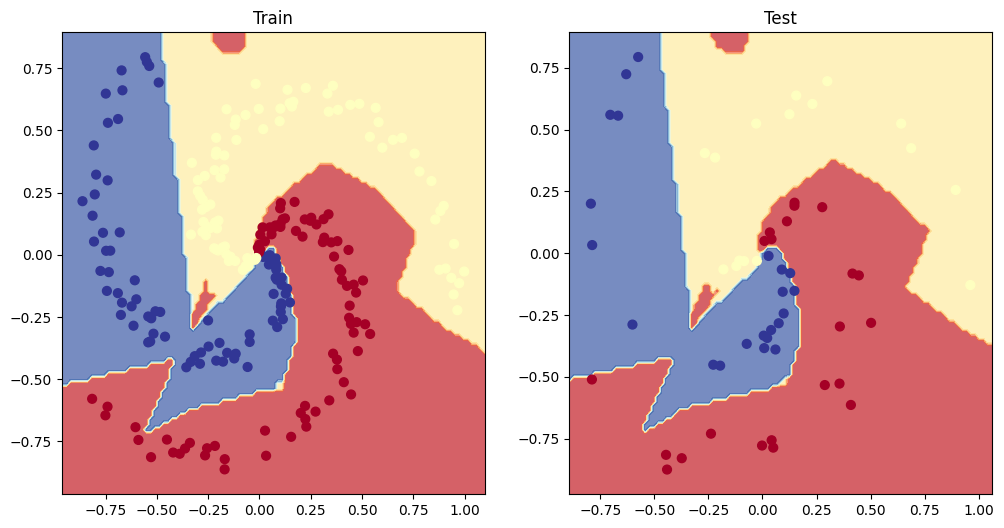

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)